# Task 14 - Motor Control
### Introduction to modeling and simulation of human movement
https://github.com/BMClab/bmc/blob/master/courses/ModSim2018.md

In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
import math

%matplotlib notebook

### Muscle properties

In [2]:
Lslack = .223
Umax = .04
Lce_o = .093 #optmal l
width = .63#*Lce_o
Fmax = 1400
a = 0
u = 0.5
#b = .25*10#*Lce_o 

### Initial conditions

In [3]:
Lnorm_ce = .087/Lce_o #norm
t0 = 0
tf = 1
h = 1e-3
m = 10
g = 9.81
Rcm = 0.264
I = 0.1832
Rf = 0.033
phi = np.pi/2
phid = 0

In [4]:
#Parâmetros da pessoa e outros parâmetros úteis

g = 9.8
m_raissa= 75 #kg
m_segment = 0.0145
m_foot = m_raissa*m_segment
rgprox = 0.690
L_foot_raissa = 0.26 #m
Rcm = 0.5*L_foot_raissa #Centro de massa do pé
I =m_foot*(rgprox*L_foot_raissa)**2  #Momento de Inércia

In [5]:
t = np.arange(t0,tf,h)
F = np.empty(t.shape)
Fkpe = np.empty(t.shape)
FiberLen = np.empty(t.shape)
TendonLen = np.empty(t.shape)
a_dynamics = np.empty(t.shape)
Phi = np.empty(t.shape)
fiberVelocity = np.empty(t.shape)

## Simulation - Series

for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 + .1*(t[i]-1)
        #print(Lm)
    
    #shortening at 4cm/s
    Lsee = Lm - Lce
    
    if Lsee<Lslack: 
        F[i] = 0
    else: 
        F[i] = Fmax*((Lsee-Lslack)/(Umax*Lslack))**2
        
        
    #isometric force at Lce from CE force length relationship
    F0 = max([0, Fmax*(1-((Lce-Lce_o)/width)**2)])
    
    #calculate CE velocity from Hill's equation
    if  F[i]>F0: print('Error: cannot do eccentric contractions')
    
    Lcedot = -b*(F0-F[i])/(F[i]+a) #vel is negative for shortening
    
    # --- Euler integration step
    Lce += h*Lcedot

    

In [6]:
def TendonForce (Lnorm_see,Lslack, Lce_o):
    '''
    Compute tendon force

    Inputs:
        Lnorm_see = normalized tendon length
        Lslack = slack length of the tendon (non-normalized)
        Lce_o = optimal length of the fiber
    
    Output:
        Fnorm_tendon = normalized tendon force
        
    '''
    Umax = .04
    
    if Lnorm_see<Lslack/Lce_o: 
        Fnorm_tendon = 0
    else: 
        Fnorm_tendon = ((Lnorm_see-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return Fnorm_tendon

In [7]:
def ParallelElementForce (Lnorm_ce):
    '''
    Compute parallel element force
    
    Inputs:
        Lnorm_ce = normalized contractile element length
    
    Output:
        Fnorm_kpe = normalized parallel element force

    '''
    Umax = 1
    
    if Lnorm_ce< 1: 
        Fnorm_kpe = 0
    else: 
        Fnorm_kpe = ((Lnorm_ce-1)/(Umax*1))**2 
        
    return Fnorm_kpe

In [8]:
def ForceLengthCurve (Lnorm_ce,width):
    F0 = max([0, (1-((Lnorm_ce-1)/width)**2)])
    return F0

In [9]:
def ContractileElementDot(F0, Fnorm_CE, a, b):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    if  Fnorm_CE>F0: print('Error: cannot do eccentric contractions')
    
    Lnorm_cedot = -b*(F0-Fnorm_CE)/(Fnorm_CE + a) #vel is negative for shortening
    
    return Lnorm_cedot

In [10]:
def ContractileElementDot(F0, Fnorm_CE, a):
    
    '''
    Compute Contractile Element Derivative

    Inputs:
        F0 = Force-Length Curve
        Fce = Contractile element force
    
    Output:
        Lnorm_cedot = normalized contractile element length derivative

    '''
    
    FMlen = 1.4 # young adults
    Vmax = 10  # young adults
    Af = 0.25  #force-velocity shape factor
    
    Fnorm_CE = min(FMlen*a*F0 - 0.001, Fnorm_CE)
    
    if  Fnorm_CE > a*F0:
        
        b = ((2 + 2/Af)*(a*F0*FMlen - Fnorm_CE))/(FMlen-1)
        
    elif Fnorm_CE <= a*F0:
        
        b = a*F0 + Fnorm_CE/Af
    
    Lnorm_cedot = (.25 + .75*a)*Vmax*((Fnorm_CE - a*F0)/b)
    
    return Lnorm_cedot

In [11]:
def ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha):
    '''
    Compute Contractile Element force

    Inputs:
        Fnorm_tendon = normalized tendon force
        Fnorm_kpe = normalized parallel element force
    
    Output:
        Fnorm_CE = normalized contractile element force
    '''
    Fnorm_CE = Fnorm_tendon/np.cos(alpha) - Fnorm_kpe
    return Fnorm_CE

In [12]:
def tendonLength(Lm,Lce_o,Lnorm_ce, alpha):
    '''
    Compute tendon length
    
    Inputs:
        Lm = 
        Lce_o = optimal length of the fiber
        Lnorm_ce = normalized contractile element length
    
    Output:
        Lnorm_see = normalized tendon length   
    '''
    Lnorm_see = Lm/Lce_o - Lnorm_ce*np.cos(alpha)
    
    return Lnorm_see

In [13]:
def activation(a,u,dt):
    '''
    Compute activation
    
    Inputs:
        u = idealized muscle excitation signal, 0 <= u <= 1
        a = muscular activation
        dt = time step
    
    Output:
        a = muscular activation  
    '''
    
    tau_deact = 50e-3 #young adults
    tau_act = 15e-3
    
    if u>a:
        tau_a = tau_act*(0.5+1.5*a)
    elif u <=a:
        tau_a = tau_deact/(0.5+1.5*a)
    
    #-------
    dadt = (u-a)/tau_a # euler
    
    a += dadt*dt
    #-------
    return a

In [14]:
def AngularAceleration(Rf,Fnorm_tendon,m,g,Rcm,I, phi):
    '''
    Compute activation
    
    Inputs:
        Rf = moment arm of quadriceps
        Fnorm_CE 
        m = segment mass
        g = acceleration of gravity
        Rcm = distance knee joint to centre of mass
        I - moment of inertia
        phi = start as 90 degree flexion and zero velocity
    
    Output:
        phidd = angular acceleration  
    '''
   
    h = 0.0005
    
    M = Rf*Fnorm_tendon - m*g*Rcm*np.sin(phi-(np.pi/2))
    phidd = M/I
    
       
    return phidd

In [15]:
def Moment(phi):
    '''
    Inputs:
        phi =  joint's degree 
    Output:
        Rf =  joint's moment
    '''
    
    Phi_deg = phi*180/np.pi #Degrees
    
    B0 =  4.3     
    B1 =  1.66e-2 
    B2 = -3.89e-4 
    B3 = -4.45e-6 
    B4 = -4.34e-8 
    
    Rf = (B0*Phi_deg**0 + B1*Phi_deg**1 + B2*Phi_deg**2 + B3*Phi_deg**3 + B4*Phi_deg**4)*0.01
    
    return Rf

In [16]:
def TotalLenght(phi):
    '''
    Inputs:
        phi = joint's degree 
    Output:
        Lm = total lenght
    '''
    Phi_deg = phi*180/np.pi #Degrees
    
    A0 =  30.6    
    A1 = -7.44e-2 
    A2 = -1.41e-4 
    A3 =  2.42e-6 
    A4 =  1.50e-8 
    
    Lm = (A0*Phi_deg**0 + A1*Phi_deg**1 + A2*Phi_deg**2 + A3*Phi_deg**3 + A4*Phi_deg**4)*0.01
    
    return Lm

In [17]:
def KneeMoment(Rf,Fnorm_tendon,m_foot,Rcm,phi,Fmax):
    '''
    Inputs:
        RF = Moment arm
        Fnorm_tendon = Normalized tendon force
        m_foot = Foot mass
        g = Acelleration of gravity
        Fmax= maximal isometric force
    Output:
        M = Total moment with respect to joint
    '''
    g = 9.81
    
    M = (Rf*Fnorm_tendon*Fmax) - (m*g*Rcm*np.sin(phi-np.pi/2))
        
    return M

In [18]:
def FlexionVelocity(M,I):
    '''
    Inputs:
        M = Total moment with respect to joint
        I = Moment of Inertia
    Output:
        phidd= angular aceleration of the joint
    '''

    phidd = M/I 
    
    return phidd

## Simulation - Parallel

In [19]:
#Normalizing
alpha = 25*np.pi/180
for i in range (len(t)):
    
    Lm = 0.31 - (phi - (np.pi/2))*Rf
          
    #shortening at 4cm/s
    u = 0.7 + 0.2*np.sin(np.pi*t[i])
    
    Lnorm_see = tendonLength(Lm,Lce_o,Lnorm_ce, alpha)

    Fnorm_tendon = TendonForce (Lnorm_see,Lslack, Lce_o) 
    
    Fnorm_kpe = ParallelElementForce (Lnorm_ce)     
        
    #isometric force at Lce from CE force length relationship
    F0 = ForceLengthCurve (Lnorm_ce,width)
    
    Fnorm_CE = ContractileElementForce(Fnorm_tendon,Fnorm_kpe, alpha) #Fnorm_CE = ~Fm
    
    #computing activation
    a = activation(a,u,h)
    
    #calculate CE velocity from Hill's equation    
    Lnorm_cedot = ContractileElementDot(F0, Fnorm_CE,a)
    
    #Angular Aceleration
    phidd = AngularAceleration(Rf,Fnorm_tendon,m,g,Rcm,I,phi)
    
    #Moment
    Rf = Moment(phi)
    
    #Total Lenght Size
    Lm = TotalLenght(phi)
    
    #Knee Moment
    M = KneeMoment(Rf,Fnorm_tendon,m_foot,Rcm,phi,Fmax)
    
    #Angular aceleration
    phidd = FlexionVelocity(M,I)

    # --- Euler integration step
    Lnorm_ce += h*Lnorm_cedot
    phid = phid + phidd*h;
    phi  = phi  + phid*h;

    
    F[i] = Fnorm_tendon*Fmax
    Fkpe[i] = Fnorm_kpe*Fmax
    FiberLen[i] = Lnorm_ce*Lce_o
    TendonLen[i] = Lnorm_see*Lce_o
    a_dynamics[i] = a
    Phi[i] = phi
    fiberVelocity[i]=Lnorm_cedot*Lce_o

## Plots 

<IPython.core.display.Javascript object>


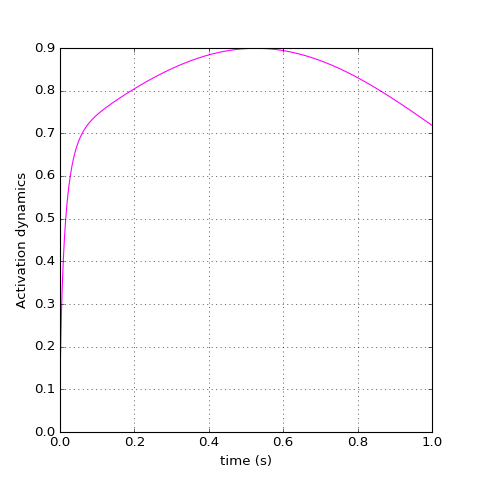

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [20]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,a_dynamics,c='magenta')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Activation dynamics')


ax.legend()

<IPython.core.display.Javascript object>


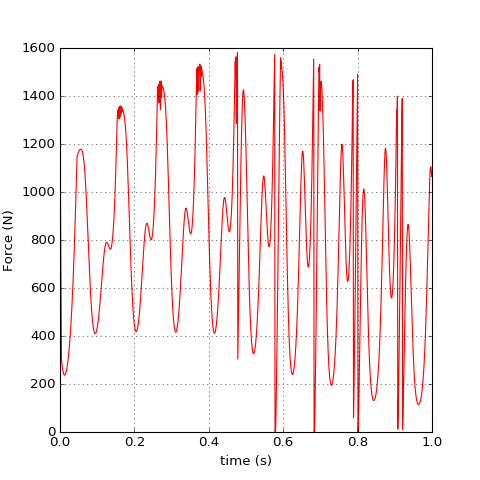

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Force (N)')


ax.legend()

<IPython.core.display.Javascript object>


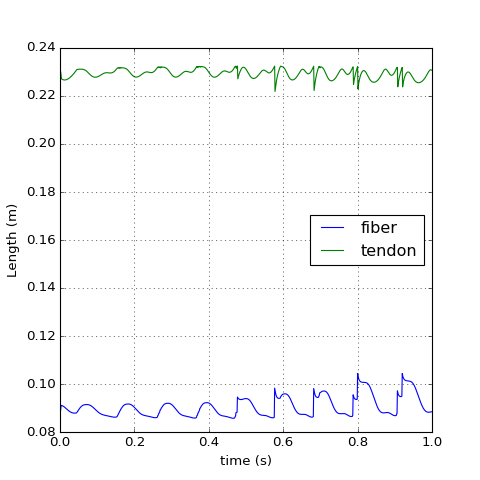

<IPython.core.display.Javascript object>


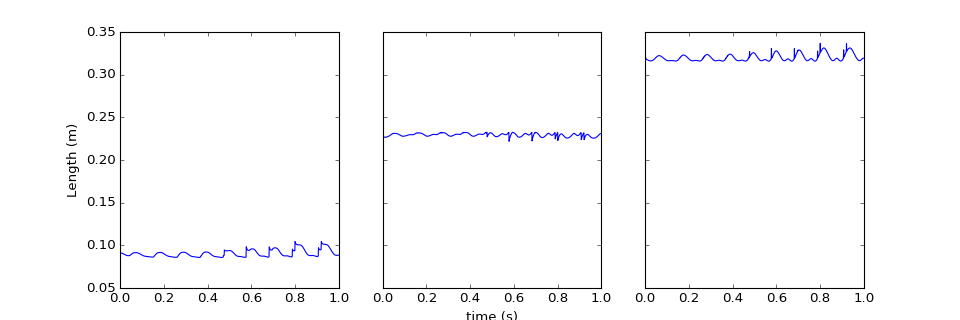

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,FiberLen, label = 'fiber')
ax.plot(t,TendonLen, label = 'tendon')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Length (m)')
ax.legend(loc='best')


fig, ax = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
ax[0].plot(t,FiberLen, label = 'fiber')
ax[1].plot(t,TendonLen, label = 'tendon')
ax[2].plot(t,FiberLen + TendonLen, label = 'muscle (tendon + fiber)')

ax[1].set_xlabel('time (s)')
ax[0].set_ylabel('Length (m)')
#plt.legend(loc='best')

<IPython.core.display.Javascript object>


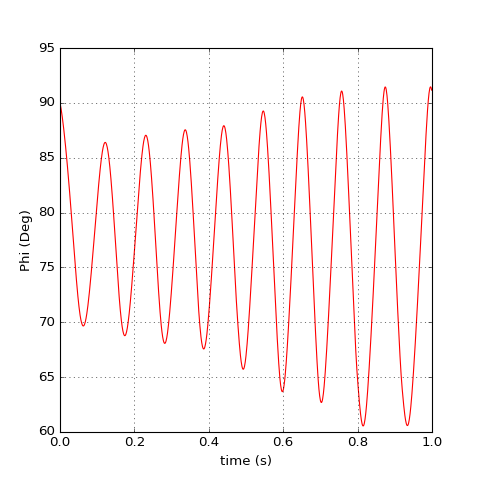

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [23]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,Phi*180/np.pi,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Phi (Deg)')


ax.legend()

<IPython.core.display.Javascript object>


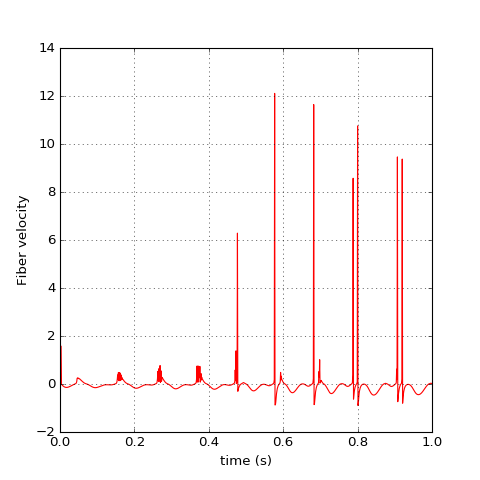

C:\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


In [24]:
fig, ax = plt.subplots(1, 1, figsize=(6,6), sharex=True)

ax.plot(t,fiberVelocity,c='red')
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('Fiber velocity')


ax.legend()